In [51]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.preprocessing import MultiLabelBinarizer
import sys
from pathlib import Path

# Ensure src is in the Python path
try:
    ROOT = Path(__file__).resolve().parent.parent
except NameError:
    ROOT = Path().resolve().parent
sys.path.append(str(ROOT))

from src.config import DATA_RAW, DATA_PROCESSED, OUTPUT_PLOTS
from src.data_loader import load_all_csv
from src.preprocessing import preprocess, basic_clean
from src.tags import tag_events, tag_frequencies
from src.anomaly_detection import detect_anomalies
from src.plotting import plot_time_with_events, plot_time_with_unplugged_events ,plot_time_with_state_bands, plot_time_with_tag_markers, plot_anomalies
pd.set_option("display.max_columns", None)

# Load Data/data_loader

In [52]:
df = load_all_csv()
df.head()

Combined data saved to ..\data\processed\merged_all_raw_data.csv


,date,time,ion_analog,voltage_ion,pressure_ion,conv_analog,voltage_conv,pressure_conv,tags
0,2025-06-23,14:06:02,444.0,2.19,2.440000e-07,193.0,0.954,0.00101,"IG on, CG on"
1,2025-06-23,14:06:03,445.0,2.20,2.500000e-07,194.0,0.959,0.00103,"IG on, CG on"
2,2025-06-23,14:06:04,444.0,2.19,2.440000e-07,194.0,0.959,0.00103,"IG on, CG on"
3,2025-06-23,14:06:05,445.0,2.20,2.500000e-07,194.0,0.959,0.00103,"IG on, CG on"
4,2025-06-23,14:06:06,444.0,2.19,2.440000e-07,193.0,0.954,0.00101,"IG on, CG on"


# Clean data/preprocessing

In [53]:
# drops unnecessary columns like analog and merges date and time to datetime column
df_cleaned = basic_clean(df)
df_cleaned.head()

,datetime,voltage_ion,pressure_ion,voltage_conv,pressure_conv,tags
0,2025-06-23 14:06:02,2.19,2.440000e-07,0.954,0.00101,"IG on, CG on"
1,2025-06-23 14:06:03,2.20,2.500000e-07,0.959,0.00103,"IG on, CG on"
2,2025-06-23 14:06:04,2.19,2.440000e-07,0.959,0.00103,"IG on, CG on"
3,2025-06-23 14:06:05,2.20,2.500000e-07,0.959,0.00103,"IG on, CG on"
4,2025-06-23 14:06:06,2.19,2.440000e-07,0.954,0.00101,"IG on, CG on"


In [54]:
df_cleaned.info()
df_cleaned.describe()
# save the cleaned dataframe
#df_cleaned.to_csv(DATA_PROCESSED / "raw_with_datetime.csv", index=False)
print("\nMissing values in each column:")
print(df_cleaned.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20047 entries, 0 to 20046
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   datetime       20047 non-null  datetime64[ns]
 1   voltage_ion    19570 non-null  float64       
 2   pressure_ion   19570 non-null  float64       
 3   voltage_conv   19387 non-null  float64       
 4   pressure_conv  19387 non-null  float64       
 5   tags           20047 non-null  object        
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 939.8+ KB

Missing values in each column:
datetime           0
voltage_ion      477
pressure_ion     477
voltage_conv     660
pressure_conv    660
tags               0
dtype: int64


In [72]:
df_cleaned["IC_unplugged"] = df_cleaned[["voltage_ion", "pressure_ion"]].isna().all(axis=1)


df_cleaned["CC_unplugged"] = df_cleaned[["voltage_conv", "pressure_conv"]].isna().all(axis=1)


#show only unplugged events
df_unplugged = df_cleaned[df_cleaned["IC_unplugged"]]
print(f"\nUnplugged events: {len(df_unplugged)}")
df_unplugged.head()


Unplugged events: 477


,datetime,voltage_ion,pressure_ion,voltage_conv,pressure_conv,tags,IC_unplugged,CC_unplugged,tag_list
8427,2025-07-02 15:53:36,NaN,NaN,0.959,0.00103,"IG turn off, CG on",True,False,"[IG turn off, CG on]"
8428,2025-07-02 15:57:06,NaN,NaN,0.959,0.00103,"IG off, CG on",True,False,"[IG off, CG on]"
8470,2025-07-02 16:47:13,NaN,NaN,0.954,0.00101,"IG turn off, CG on",True,False,"[IG turn off, CG on]"
8471,2025-07-02 16:58:13,NaN,NaN,0.959,0.00103,"IG off, CG on",True,False,"[IG off, CG on]"
8472,2025-07-02 17:01:13,NaN,NaN,0.954,0.00101,"IG off, CG on",True,False,"[IG off, CG on]"


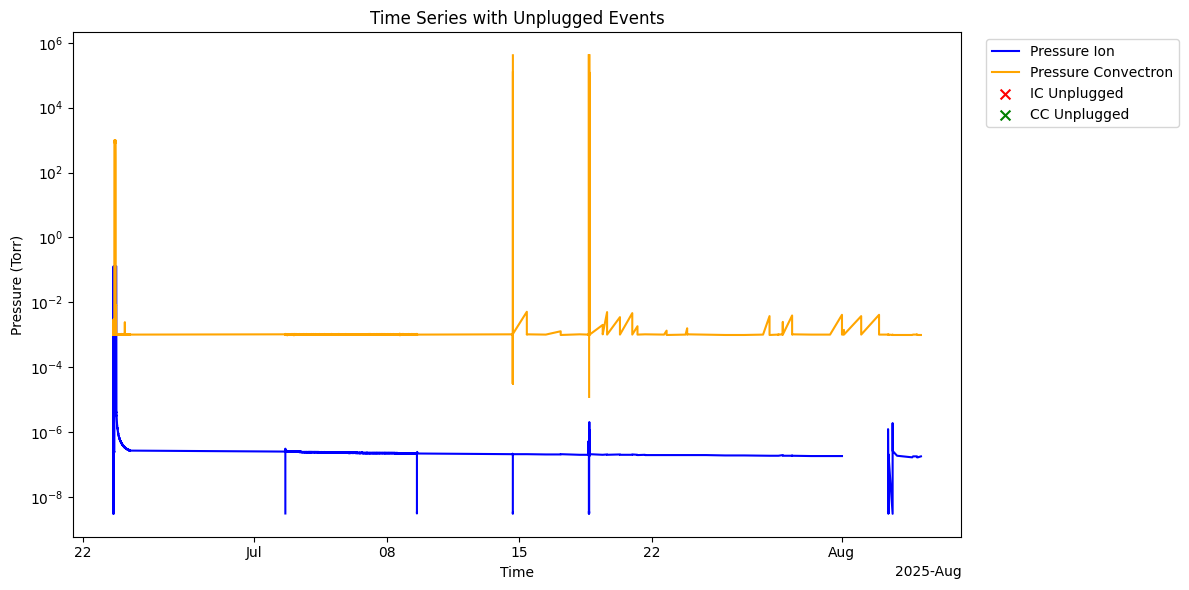

In [ ]:
plot_time_with_unplugged_events(df_cleaned, savepath=OUTPUT_PLOTS / "time_with_unplugged_events.png")


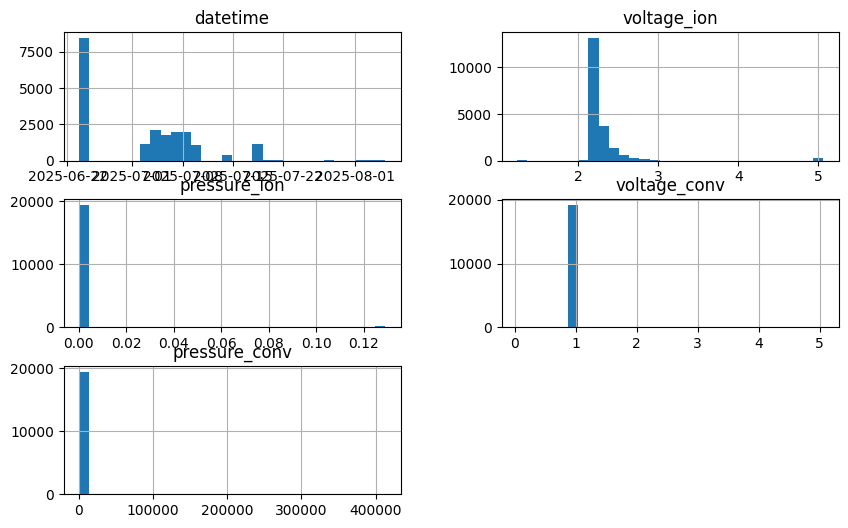

In [57]:
df_cleaned.hist(bins=30, figsize=(10,6))
plt.show()

<Axes: >

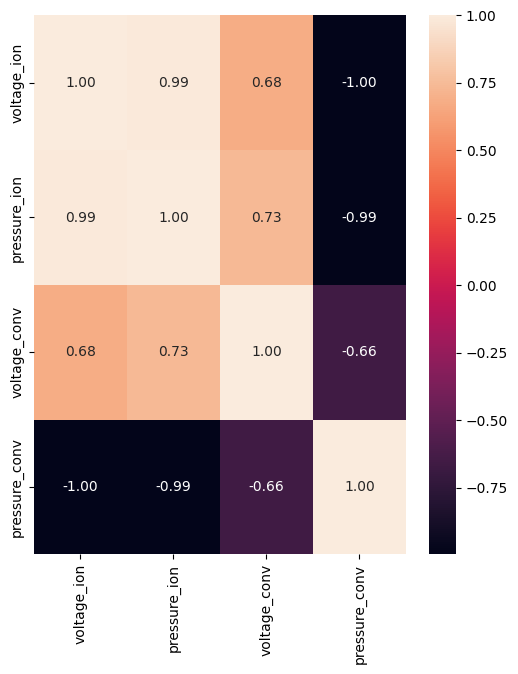

In [58]:
import seaborn as sns
df_heatmapv1 = df_cleaned.select_dtypes(include='number').corr()
plt.figure(figsize=(6, 7))
sns.heatmap(df_heatmapv1.corr(), annot=True, fmt=".2f")

# Tags analysis

Create binary columns for key tag types

In [59]:
# Parse tags into list
# Add binary columns for using MultiLabelBinarizer from sklearn
# Derive IG_state & CG_state

df_tags = tag_events(df_cleaned)

df_tags.head()

,datetime,voltage_ion,pressure_ion,voltage_conv,pressure_conv,tags,IC_unplugged,CC_unplugged,tag_list,tag_IG_on,tag_IG_off,tag_IG_fail,tag_IG_turn_on,tag_IG_turn_off,tag_IG_slow_on,tag_CG_on,tag_CG_off,tag_CG_turn_off,tag_CG_turn_on,tag_gate_manipulation,tag_RP_on,tag_chamber_open,tag_venting,IG_state,CG_state,CH_state
0,2025-06-23 14:06:02,2.19,2.440000e-07,0.954,0.00101,"IG on, CG on",False,False,"[IG on, CG on]",1,0,0,0,0,0,1,0,0,0,0,0,0,0,IG on,CG on,CH normal
1,2025-06-23 14:06:03,2.20,2.500000e-07,0.959,0.00103,"IG on, CG on",False,False,"[IG on, CG on]",1,0,0,0,0,0,1,0,0,0,0,0,0,0,IG on,CG on,CH normal
2,2025-06-23 14:06:04,2.19,2.440000e-07,0.959,0.00103,"IG on, CG on",False,False,"[IG on, CG on]",1,0,0,0,0,0,1,0,0,0,0,0,0,0,IG on,CG on,CH normal
3,2025-06-23 14:06:05,2.20,2.500000e-07,0.959,0.00103,"IG on, CG on",False,False,"[IG on, CG on]",1,0,0,0,0,0,1,0,0,0,0,0,0,0,IG on,CG on,CH normal
4,2025-06-23 14:06:06,2.19,2.440000e-07,0.954,0.00101,"IG on, CG on",False,False,"[IG on, CG on]",1,0,0,0,0,0,1,0,0,0,0,0,0,0,IG on,CG on,CH normal


# Summary tag frequencies

In [60]:
# Tag frequencies
print("Tag Frequencies:\n", tag_frequencies(df_tags))

Tag Frequencies:
                   Tag  Count
0               CG on  19374
1               IG on  19276
2              IG off    719
3              CG off    658
4             venting    136
5               RP on    120
6   gate manipulation     64
7          IG turn on     27
8          IG slow on     18
9          CG turn on     12
10       chamber open     11
11        IG turn off     10
12        CG turn off      5
13            IG fail      5


# Detect anomalies

In [61]:
df_altered = detect_anomalies(df_tags)
num_anomalies = (df_altered["anomaly_if"] == -1).sum()
print(f"Number of anomalies detected: {num_anomalies}")

Number of anomalies detected: 199


In [62]:
#df_altered[df_altered['anomaly_if'] == 1].describe()
df_anomalies = df_altered[df_altered['anomaly_if'] == -1]
df_anomalies.head()

,datetime,voltage_ion,pressure_ion,voltage_conv,pressure_conv,tags,IC_unplugged,CC_unplugged,tag_list,tag_IG_on,tag_IG_off,tag_IG_fail,tag_IG_turn_on,tag_IG_turn_off,tag_IG_slow_on,tag_CG_on,tag_CG_off,tag_CG_turn_off,tag_CG_turn_on,tag_gate_manipulation,tag_RP_on,tag_chamber_open,tag_venting,IG_state,CG_state,CH_state,anomaly_if,score_if_raw,score_if
224,2025-06-23 15:37:49,5.06,0.129,2.84,9.04,"IG off, CG on, venting",False,False,"[IG off, CG on, venting]",0,1,0,0,0,0,1,0,0,0,0,0,0,1,IG off,CG on,venting,-1,-0.012986,0.012986
225,2025-06-23 15:37:50,5.06,0.129,2.85,9.71,"IG off, CG on, venting",False,False,"[IG off, CG on, venting]",0,1,0,0,0,0,1,0,0,0,0,0,0,1,IG off,CG on,venting,-1,-0.013734,0.013734
226,2025-06-23 15:37:51,5.06,0.129,2.87,10.40,"IG off, CG on, venting",False,False,"[IG off, CG on, venting]",0,1,0,0,0,0,1,0,0,0,0,0,0,1,IG off,CG on,venting,-1,-0.013734,0.013734
227,2025-06-23 15:37:52,5.06,0.129,2.88,10.90,"IG off, CG on, venting",False,False,"[IG off, CG on, venting]",0,1,0,0,0,0,1,0,0,0,0,0,0,1,IG off,CG on,venting,-1,-0.013921,0.013921
228,2025-06-23 15:37:53,5.06,0.129,2.89,11.50,"IG off, CG on, venting",False,False,"[IG off, CG on, venting]",0,1,0,0,0,0,1,0,0,0,0,0,0,1,IG off,CG on,venting,-1,-0.014670,0.014670


In [63]:
# stats
#print(df_altered[["pressure_ion","pressure_conv"]].describe())
#print(df_altered["IG_state"].value_counts())
print(df_altered["CH_state"].value_counts())

CH_state
CH normal            19727
venting                125
RP on                  120
gate manipulation       64
chamber open            11
Name: count, dtype: int64


# Plots

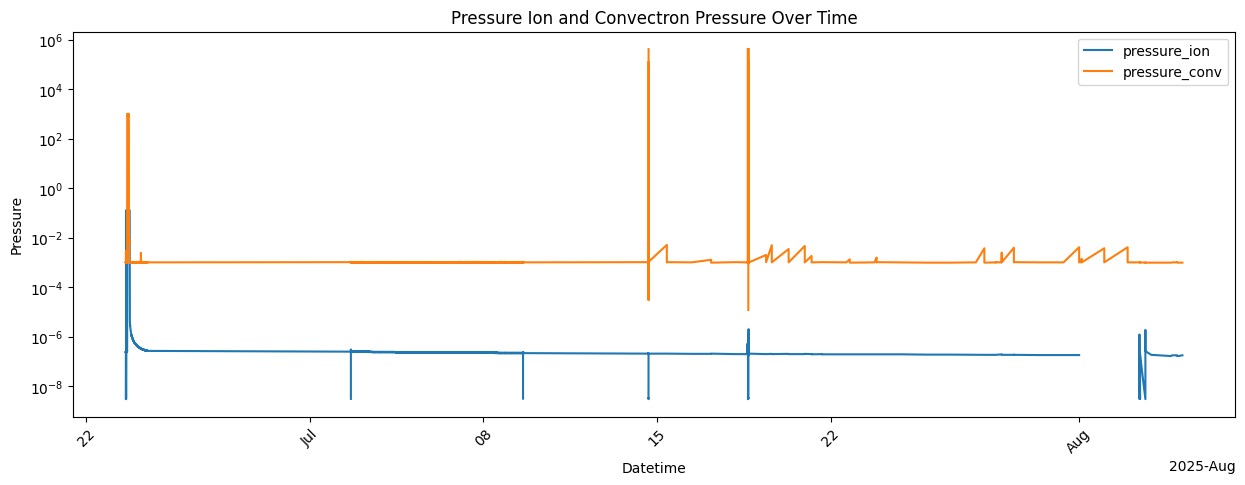

In [ ]:
#  time vs ion and convectron pressure w event markers
p_time_with_events = plot_time_with_events(
    df_altered,
    savepath=OUTPUT_PLOTS / "pressure_over_time.png"
)

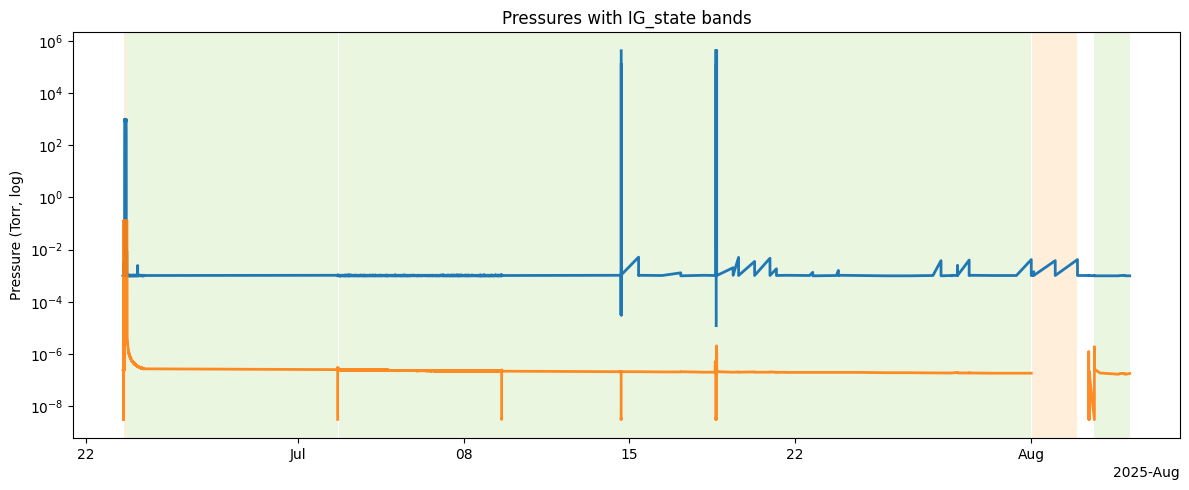

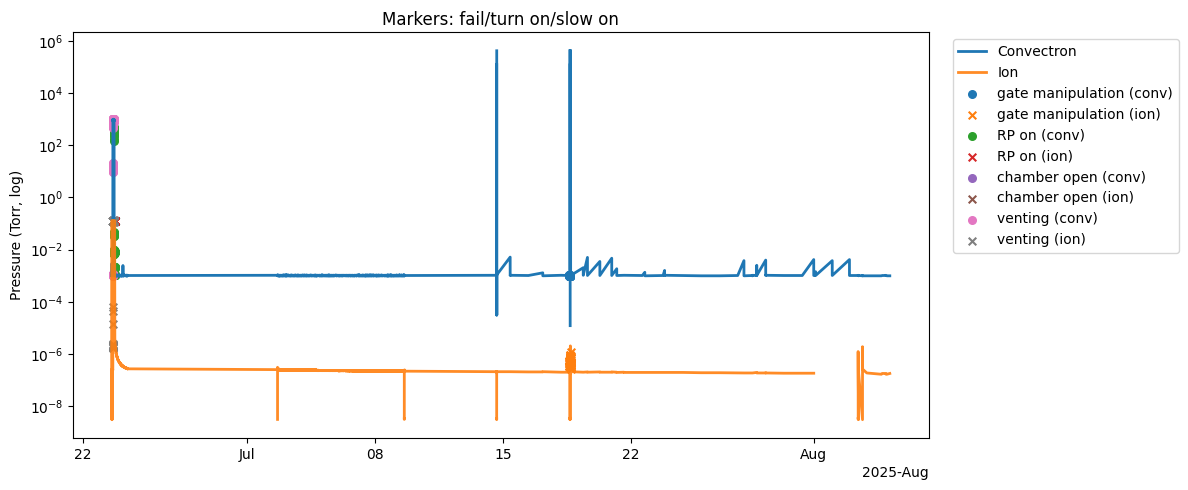

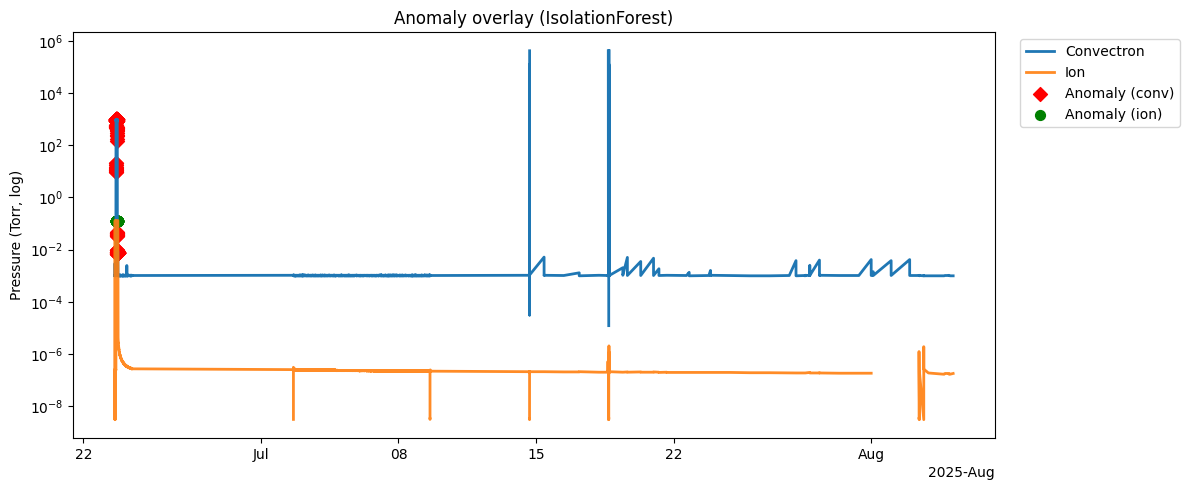

In [65]:

# for visualization of IG_state and CH_state bands by time, each band is a ig state
plot_time_with_state_bands(df_altered.copy().reset_index(), title="Pressures with IG_state bands", )

plot_time_with_tag_markers(
    df_altered.copy().reset_index(),
    title="Markers: fail/turn on/slow on"
)

plot_anomalies(df_altered.copy().reset_index(), title="Anomaly overlay (IsolationForest)")


In [66]:
out = DATA_PROCESSED / "processed_edaALL.csv"
df_altered.to_csv(out, index=False)
print(f"Saved combined data to {out}")

Saved combined data to ..\data\processed\processed_edaALL.csv
